# **Debugging notebook**
### AUTHOR: Martí Cortada Garcia
---

In [1]:
# Required packages
from Bio import Phylo
from io import StringIO
from Bio import SeqIO
import numpy as np
import sympy as sp

In [2]:
def generate_alignment(length, distribution):
    """
    Generates an alignment of length `length` using a given `distribution`.
    """
    seq = ''
    for i in range(length):
        # generate a random sample from the multinomial distribution
        nucleotide = np.random.choice(['A', 'G', 'C', 'T'], p=distribution)
        seq += nucleotide
    return seq

distribution = [0.25, 0.25, 0.25, 0.25] # equal distribution
alignment = generate_alignment(1000, distribution)
print(alignment)

TAGGTTATACCATAAACCACCTTTGACCTGATCTGACGTTGGCAATGTGATGTAAGTCATTATCACCTATTGGATGGGCCGCGGAGATATATACAATAGTGGCCCTGTCATCCAACTCTTGGTTTTCTCCTCTGTTACCACGCCTCGAGGAGAGTGCAAGCATTACGAAGTCCGATTCTTTTCGTTGATATCATCACGTAGATAATAATTAAACAGGGAACATTAACCTAGCCCACACAAACGGATAAGCATCGTGTATTGTGAAAGCTTGTGCGAAGACTCCAGCACTCATACTCTACCGGCGCTTAAACGACCTTGGGGCACCGCTCAGCCACGGTTGACTGACAACCCTGAGCCGCCATGCGGTGGCCGGGTGTTACATGAGTCGTGTCGAGTAGTACTGAGCACTCAAGGCCAACGGTGACCTCCCATTTACACTCTAGCGCCTCATAAGCAAAGGCGATAGAGCTTGCTTTGGATTTGGGTGTGTAGGTACGTGAGTTACAGGCCACCATGCTAGCGTCGACATCCTTATATCGAGAACGTAGTACGGAGTCATGGACTCCATCTTATGGGCCATTTATCAAAGGAAGACGGATCATGAAACCCCATTTCTATGAGCATGTTATGTGCGTCCGAGAAAGATTTTTGATTCCATAGTCGTCTCGACGACTCCTGATGCTCCTGTGCGCTCCCGTCGCATTCATGAACAGCACATCTCGGTCCTCCATAGAGGCGTGTACGCACACGCCCTAGTCCCCCCGCACAGCACTGGTTTATATAATGCGCCGAGCCGCCTTGATAGTCTTGGCAGCTAATATGGTAAGCACACGGCTCCTCAATACGCACAAAGTACCGAGTTTGTCAGTGAGTGTCAGCGGTTTCCCAAGCGCGTCCCGTGGTGAGCTACCGACGGCATAGCACTTGCAATTGGTCCGTTTTAGCACATGACGCAGGGACGTTTAAGTATCTCACCTCGCCTAAATTTCGAGCTAGTTGC

---

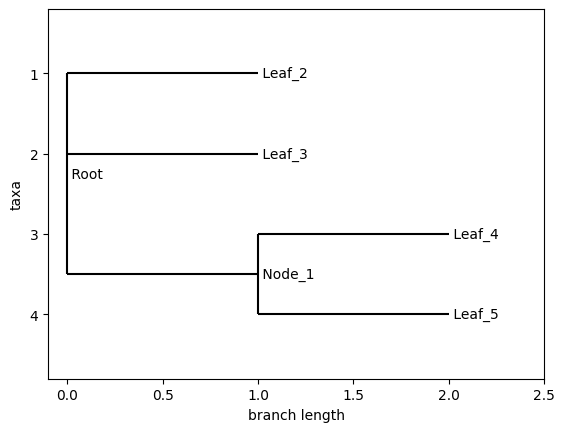

In [3]:
newick_tree = "(2,3,(4,5))"
# newick_tree = "(A,B,C)"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Node_" + str(idx) if idx > 0 else "Root" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [10]:
from sympy import symbols, Eq, solve
from scipy.linalg import expm
new_distribution = [0.22, 0.24, 0.26, 0.28]

class Edge:
    def __init__(self, edge, transition_matrix=None):
        self.edge = edge
        self.transition_matrix = transition_matrix

node_distribution = dict()
node_distribution["Root"] = np.array([0.25]*4)
node_sequence = dict()
node_sequence["Root"] = generate_alignment(1000, node_distribution["Root"])
print(node_distribution["Root"])
l = 1

# Return a matrix from a dicrionary
def get_matrix_from_dict(d):
    Q2 = np.zeros((4,4))
    coefficients = list(d.values())
    for i in range(4):
        for j in range(4):
            Q2[i,j] = coefficients[i*4+j]
    return Q2

def alpha(new_distribution, Q, i, k):
    return min(1, (new_distribution[k]*Q[k,i])/(new_distribution[i]*Q[i,k]))

def get_M2(new_distribution,d2):
    P = np.zeros((4,4))
    iter = True
    while iter:
        Q = np.zeros((4,4))
        i=0
        while i<4:
            # posar el paràmere de la diagoal a 10 i els altres 1
            # 10 * e**(-l)
            dir = np.ones(4)
            dir[i] = 50*np.exp(-l)
            R = np.random.dirichlet(dir)
            if R[i] > 0.3:
                Q[i,:] = R 
                i = i + 1   # RANDOM O AMB EPSILONS???, DE MOMENT RANDOM!
        print("new_distribution", new_distribution)
        print("np.matmul(new_distribution,Q)", np.matmul(new_distribution,Q))
        print("---"*30)
        for i in range(4):
            for j in range(4):
                if i == j:
                    sum = 0
                    for k in range(4):
                        if k != i:
                            sum += (Q[i,k] * (1 - alpha(new_distribution,Q,i,k)))
                    P[i,j] = Q[i,i] + sum
                else:
                    P[i,j] = Q[i,j]*alpha(new_distribution,Q,i,j)
        print("new_distribution", new_distribution)
        print("np.matmul(new_distribution,P)", np.matmul(new_distribution,P))
        assert (np.abs(np.sum(new_distribution - np.matmul(new_distribution,P)))) < 10**-6
        # Adjust the matrix diagonalising
        vaps, _ = np.linalg.eig(P)
        vaps = sorted(vaps, reverse=True)
        print(vaps)
        print("***"*30)
        A = symbols('A')
        eq = Eq(-d2+(((1-A)*vaps[1]+A)*((1-A)*vaps[2]+A)*((1-A)*vaps[3]+A)),0)
        sol = solve(eq, A)
        print(sol, "***"*30)
        # We only want the real solution between 0 and 1
        # sol = [s for s in sol if s.is_real and s > 0 and s < 1]  ## MARTA, POSEM TOTES LES ENTRE 0 I 1???
        # 10*-22 I com ho considerem? Fem try except o ens el prenem real
        res = 0
        for s in sol:
            if s.is_real and s > 0 and s < 1:
                res = s
                res = np.float64(res)
                P = (1-res)*P + res*np.identity(4)
                iter = False
                break
            elif s.is_complex:
                b = np.imag(s)
                a = sp.re(s)
                print("a", a)
                print("b", b)
                if np.abs(b) < 10**-20 and a > 0 and a < 1:
                    res = sp.re(s)
                    res = np.float64(res)
                    P = (1-res)*P + res*np.identity(4)
                    iter = False
                    break
        print(sol)
    return P
        
def generate_random_matrix(distribution):
    # Comentar...
    print('---'*30)
    res = 1
    while res >= 1:
        # Generant...
        M1 = np.zeros((4,4))
        i=0
        while i<4:
            # posar el paràmere de la diagoal a 10 i els altres 1
            # 10 * e**(-l)
            dir = np.ones(4)
            dir[i] = 50*np.exp(-l)
            R = np.random.dirichlet(dir)
            if R[i] > 0.3:
                M1[i,:] = R 
                i = i + 1
        #print("M1", M1)
            
        new_distribution = np.matmul(distribution,M1)
        print('Comprovació 1:')
        D = np.diag(distribution)
        D_ = np.diag(new_distribution)
        res = np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D))
        print("res", res)
        print('---'*30)
        print("Comprovació 2")
        detM1 = np.linalg.det(M1)
        print("DetM1 = ", detM1)
        if detM1 > np.exp(-l)*np.sqrt(np.linalg.det(D_))/np.sqrt(np.linalg.det(D)):
            pass
        else:
            res = 1
    print('---'*30)
    print("Creem M2")
    d2 = np.exp(-l)*np.sqrt(np.linalg.det(D_))/(detM1*np.sqrt(np.linalg.det(D)))
    M2 = get_M2(new_distribution,d2) ##
    print("M2 = ", M2)
    print("d2 = ", d2)
    print('---'*30)
    detM2 = np.linalg.det(M2) 
    print("detM2 = ", detM2)
    assert(np.abs(detM2 - d2) < 10**-6)
    print("Obtenim M")
    M = np.matmul(M1,M2)
    print("M = ", M)
    print('---'*30)
    print("Comprovem que d1·d2=detM")
    print("d1·d2 = ", np.linalg.det(M1)*np.linalg.det(M2))
    print("detM = ", np.linalg.det(M))
    return M

def generate_sequences(M, seq):
    new_seq = ""
    for s in seq:
        if s == "A":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[0,:])
        elif s == "G":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[1,:])
        elif s == "C":
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[2,:])
        else:
            new_seq += np.random.choice(['A', 'G', 'C', 'T'], p=M[3,:])
    return new_seq

iter = 0
edges = []
root_ditribution = np.array([0.25]*4)
for edge in net.edges():
    new_edge = Edge(edge, generate_random_matrix(node_distribution[edge[0].name]))
    edges.append(new_edge)
    print(new_edge.transition_matrix)
    node_distribution[edge[1].name] = np.matmul(node_distribution[edge[0].name],new_edge.transition_matrix)
    print(new_edge.transition_matrix)
    for i in range(4):
        assert(np.sum(new_edge.transition_matrix[i,:])<1.000000001 and np.sum(new_edge.transition_matrix[i,:])>0.999999999)
    # create alignment for the node
    node_sequence[edge[1].name] = generate_sequences(new_edge.transition_matrix, node_sequence[edge[0].name])
    print('---'*30)
    print('---'*30)
    iter += 1

assert(iter == len(net.edges()))

[0.25 0.25 0.25 0.25]
------------------------------------------------------------------------------------------
Comprovació 1:
res 0.363965742331906
------------------------------------------------------------------------------------------
Comprovació 2
DetM1 =  0.47567770984536295
------------------------------------------------------------------------------------------
Creem M2
new_distribution [0.25430768 0.23848187 0.28924163 0.21796881]
np.matmul(new_distribution,Q) [0.21968121 0.2534203  0.29568963 0.23120885]
------------------------------------------------------------------------------------------
new_distribution [0.25430768 0.23848187 0.28924163 0.21796881]
np.matmul(new_distribution,P) [0.25430768 0.23848187 0.28924163 0.21796881]
[1.0, 0.964833866703713, 0.9361232164812945, 0.9144124004097922]
******************************************************************************************
[-0.379832209053522, -26.1978468988084 - 12.0648294920935*I, -26.1978468988084 + 12.0648294

In [11]:
for e in edges:
    print(e.edge[0].name, e.edge[1].name)
    print(e.transition_matrix)
    print('---'*30)
    # Comprovacions que es compleixi que sigui "larger-value-diagonal matrices"
    for i in range(4):
        assert(e.transition_matrix[i,i] == max(e.transition_matrix[i,:]))

Root Leaf_2
[[0.91510328 0.02562046 0.03605504 0.02322122]
 [0.04660554 0.67984881 0.22482157 0.04872408]
 [0.02716285 0.13237576 0.81294435 0.02751704]
 [0.02835905 0.11608247 0.08314558 0.7724129 ]]
------------------------------------------------------------------------------------------
Root Leaf_3
[[0.7754766  0.11644028 0.01349077 0.09459235]
 [0.08206147 0.84226626 0.02531016 0.05036212]
 [0.12762305 0.02976943 0.73446362 0.1081439 ]
 [0.0965901  0.02503547 0.08144403 0.7969304 ]]
------------------------------------------------------------------------------------------
Root Node_1
[[0.80427093 0.12192208 0.02167301 0.05213398]
 [0.09626216 0.74259208 0.03327571 0.12787005]
 [0.05542798 0.02466833 0.8398493  0.0800544 ]
 [0.05732702 0.14143862 0.02537132 0.77586304]]
------------------------------------------------------------------------------------------
Node_1 Leaf_4
[[0.74402476 0.0297962  0.13549712 0.09068192]
 [0.01655277 0.92873696 0.03209232 0.02261795]
 [0.08274125 0.0

In [31]:
for n in node_sequence:
    print(n, node_sequence[n])
    print('---'*30)

Root TACATAGCAGAGTCGAGCCAAGACAAAAATCTGCTATAAACGGGATGCCGGTTTCTGCAACCAAGCGGAATGATAGCTACCTCACTGGTTGGGATCCATTGAGACGCACCTAGTCTAGTAGCTAATAGTTGAAAGACGATTGCAGCGGTAACCCTGTATCGTTATGCCCCCTCGTGATTCGAGATTGCTCTGTGGCGATTTGACTCTGACTCTACCCAATCCGAAACCAGGGGTAATGAGGCAAATGCTTCTACATGAACTAACACGGATTATCGCTTCGCACTCCTAACATACATCTAGGTGTCGTGTTTGTTAACCTGTTGGCGTCGCCACAGCTGATGCCATATTTGGTCATTCGGAGCCTCACGTGACACCCCCACACTTAACAGACTTAGACATCACTCTCAGCTGGGGTTATCCGTAGGCAATCGAGTACGGTCTGCCTAACCACAGGCTCTAGCCTAGTGCCGTGATGGGTATAACGGAAAGTGACTACAGAGATAGCGGTCAACACTCTACATACATCCAAAGACTATTCCCGCCGTCGCACCCAGGTTAATAGTAAGTGGCTGAAAGGGGCAGAGTTGGTGGAGGAGGTGACAGAGTTGTGACGGGCATATTTCCGTGAGAGGCTGACAGACTGAGTTGAGTCACGATCATAAAGTCGCTTCTTTGAACTCAAATTCGCTACCCTACATTATCGTCCCAGGAAGCAAATCCGTCTTCCTTATTCTATCCTGTAAAGGTCTTACTTGGTTACCCACTCCCAAGCACGTGTTTTAATCCGGTCCCCGCGAGATGCCCCGCTGCAGCAAGGCGTCACTGGTCGAAGACCTCCTGCCACGTGAAGGCGGTACTTACATCAGGATGCTGTGTGTCAAGGTGGCCCCACATCACCAGTTAGTAAAAAAAGTATTTGAGATTACAGTAGTATGGGTTTAACATTCGCATGAGTGTGCTCGAGCCTTCCCCCGGATAGCATGTTGGGTTCAGCG

### Save leaves alignments into ```fasta``` format

In [9]:
leaves_seq = {k: v for k, v in node_sequence.items() if k.startswith('L')}
sequences_in_leaves = list(leaves_seq.values())
keys_for_sequences = list(leaves_seq.keys())
iter = 0
file = open(str(len(sequences_in_leaves))+ "_leaves_" + str(len(sequences_in_leaves[0])) + "length_sequences.fasta", "w")
for seq in sequences_in_leaves:
    file.write(">Seq" + str(keys_for_sequences[iter]) + "\n" + seq + "\n")
    iter += 1
file.close()

IndexError: list index out of range